# OCR with own model_Part2


In the previous notebook, We trained our CNN model with a custom dataset for our OCR project. We saved that model to use later and now we will use that model to recognize handwritten letters in images. 

I try my best to explain every steps but for more details, you can check the main reference of this notebook from here : 

https://pyimagesearch.com/2020/08/24/ocr-handwriting-recognition-with-opencv-keras-and-tensorflow/?_ga=2.77586134.2138365318.1655895679-1130789896.1638882117



First we need to import necessary packages and then load our custom model

In [1]:
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import imutils
import cv2

In [2]:
print("[INFO] loading handwriting OCR model...")
model = load_model('one_epoch_resnet.model')

[INFO] loading handwriting OCR model...


Load our test image and see what it is...

In [3]:
# load the input image from disk, convert it to grayscale
image = cv2.imread('ocrtest.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray=cv2.resize(gray,(800,600))
cv2.imshow("Gray_Image", gray)
cv2.waitKey(0)

-1

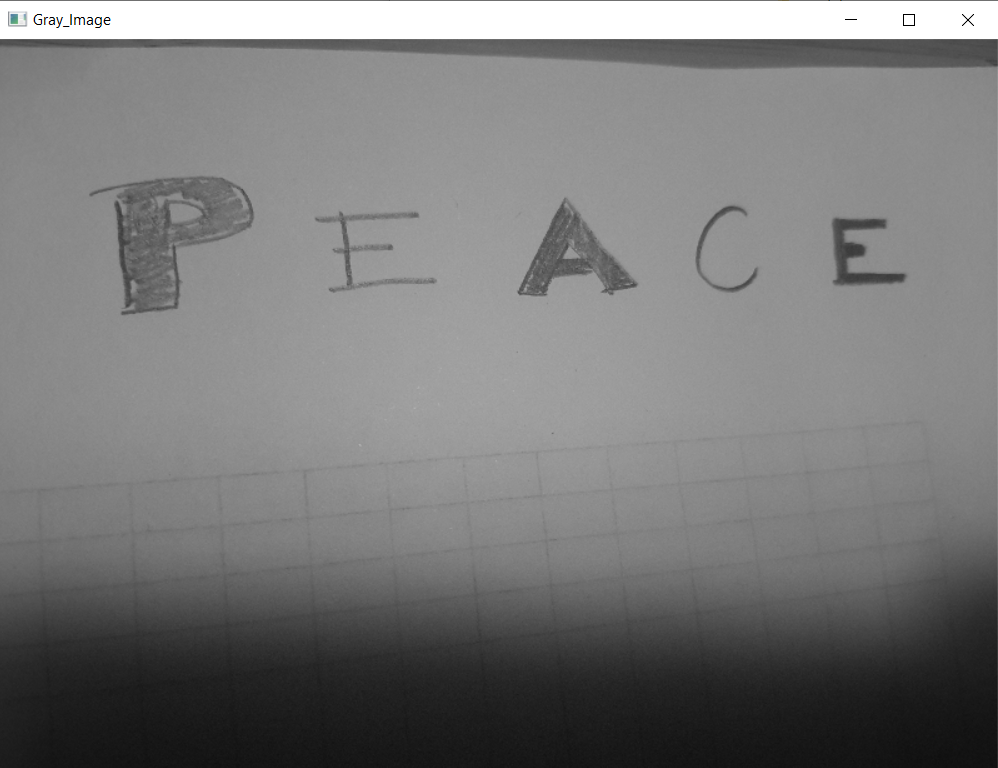


Our model can only predict a digit or letter in a roi. But we have 5 letters in this image and our model can't detect where they are. The first critical job is detecting the letters or digits. If you checked my older notebooks about Pytesseract, you can see that Pytesseract can also make detection. For this case, we need to find letters by some classical computer vision methods.

To detect letters, we need to find closed contours(cv2.findContours). After finding closed contours, We will draw a rectangle for a possible letter position. At this point, we can apply a filter to the dimension of the rectangle. The ROI of a letter should be closer to a rectangle with some ratio. This filtering operation can be different for other images. If you will use this method, you will need to check the ratio and rectangle size according to your image. After finding the proper rectangles, We will reshape all that ROIs to 32x32 which is the input dimension for our model. And also we change the image as the letter is white and the background is black(cv2.THRESH_BINARY_INV), like our custom dataset.

After resizing all ROIs and converting them binary_inverse, We will put them in the model and let the model predict. For prediction each rectangle, we will make a for loop and show the result on image and also print the 'confidence value'. 

Let's apply this recipe...




In [4]:
# preprocessing for clear contours
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

In [5]:
print(np.shape(cnts))

(16,)


C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\numpy\core\fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [6]:
#create an empty list for possible characters
chars = []

# loop over the contours
for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)

    # filter out bounding boxes, ensuring they are neither too small
    # nor too large
    if (w >= 40 and w <= 150) and (h >= 50 and h <= 120):
        # extract the character and threshold it to make the character
        # appear as *white* (foreground) on a *black* background, then
        # grab the width and height of the thresholded image
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        (tH, tW) = thresh.shape

        # if the width is greater than the height, resize along the
        # width dimension
        if tW > tH:
            thresh = imutils.resize(thresh, width=32)

        # otherwise, resize along the height
        else:
            thresh = imutils.resize(thresh, height=32)

        # re-grab the image dimensions (now that its been resized)
        # and then determine how much we need to pad the width and
        # height such that our image will be 32x32
        (tH, tW) = thresh.shape
        dX = int(max(0, 32 - tW) / 2.0)
        dY = int(max(0, 32 - tH) / 2.0)

        # pad the image and force 32x32 dimensions
        padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
                                    value=(0, 0, 0))
        padded = cv2.resize(padded, (32, 32))

        # prepare the padded image for classification via our
        # handwriting OCR model
        padded = padded.astype("float32") / 255.0
        padded = np.expand_dims(padded, axis=-1)

        # update our list of characters that will be OCR'd
        chars.append((padded, (x, y, w, h)))


In [7]:
# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")

In [8]:
# OCR the characters using our handwriting recognition model
preds = model.predict(chars)

# define the list of label names
#from the previous notebook, wee need a map for our predictions
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]


In [9]:
# loop over the predictions and bounding box locations together
for (pred, (x, y, w, h)) in zip(preds, boxes):
    # find the index of the label with the largest corresponding
    # probability, then extract the probability and label
    i = np.argmax(pred)
    prob = pred[i]
    label = labelNames[i]
    
    # draw the prediction on the image
    print("[INFO] {} - {:.2f}%".format(label, prob * 100))
    cv2.rectangle(gray, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(gray, label, (x - 10, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

    # show the image
    cv2.imshow("Image", gray)
    cv2.waitKey(0)

[INFO] R - 37.74%
[INFO] F - 64.35%
[INFO] O - 27.56%
[INFO] 0 - 8.39%
[INFO] E - 45.07%


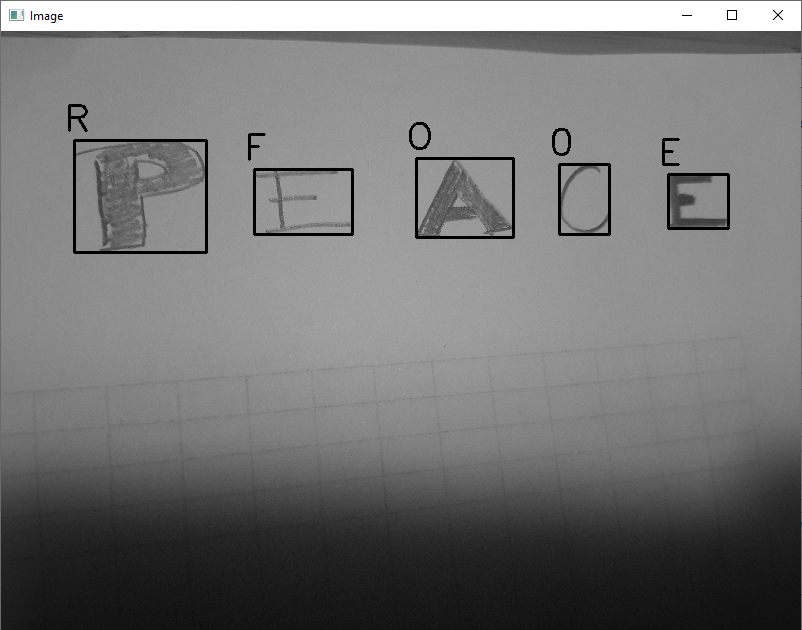



As you can, our model make a PERFECT(!!) job and only one correct prediction... 

If you follow this notebook series from training part, you will remember we trained our model only one epoch and have a bad accuracy score. Because of that reason, these wrong predictions are normal. On the otherhand, We correctly found letters' positions. 

For a good example, I also put the pretrained model with 50 epochs and want to show result with this model. I will just change the model, other steps are same.



In [10]:
print("[INFO] loading handwriting OCR model...")
model = load_model('50_epoch.model')

[INFO] loading handwriting OCR model...


In [11]:
image = cv2.imread('ocrtest.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray=cv2.resize(gray,(800,600))
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]


In [12]:
#create an empty list for possible characters
chars = []

# loop over the contours
for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)

    # filter out bounding boxes, ensuring they are neither too small
    # nor too large
    if (w >= 40 and w <= 150) and (h >= 50 and h <= 120):
        # extract the character and threshold it to make the character
        # appear as *white* (foreground) on a *black* background, then
        # grab the width and height of the thresholded image
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        (tH, tW) = thresh.shape

        # if the width is greater than the height, resize along the
        # width dimension
        if tW > tH:
            thresh = imutils.resize(thresh, width=32)

        # otherwise, resize along the height
        else:
            thresh = imutils.resize(thresh, height=32)

        # re-grab the image dimensions (now that its been resized)
        # and then determine how much we need to pad the width and
        # height such that our image will be 32x32
        (tH, tW) = thresh.shape
        dX = int(max(0, 32 - tW) / 2.0)
        dY = int(max(0, 32 - tH) / 2.0)

        # pad the image and force 32x32 dimensions
        padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
                                    value=(0, 0, 0))
        padded = cv2.resize(padded, (32, 32))

        # prepare the padded image for classification via our
        # handwriting OCR model
        padded = padded.astype("float32") / 255.0
        padded = np.expand_dims(padded, axis=-1)

        # update our list of characters that will be OCR'd
        chars.append((padded, (x, y, w, h)))


In [13]:
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")
# OCR the characters using our handwriting recognition model
preds = model.predict(chars)

In [14]:
# loop over the predictions and bounding box locations together
for (pred, (x, y, w, h)) in zip(preds, boxes):
    # find the index of the label with the largest corresponding
    # probability, then extract the probability and label
    i = np.argmax(pred)
    prob = pred[i]
    label = labelNames[i]
    
    # draw the prediction on the image
    print("[INFO] {} - {:.2f}%".format(label, prob * 100))
    cv2.rectangle(gray, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(gray, label, (x - 10, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

    # show the image
    cv2.imshow("Image", gray)
    cv2.waitKey(0)

[INFO] B - 80.99%
[INFO] E - 82.73%
[INFO] A - 99.74%
[INFO] C - 35.98%
[INFO] E - 99.07%


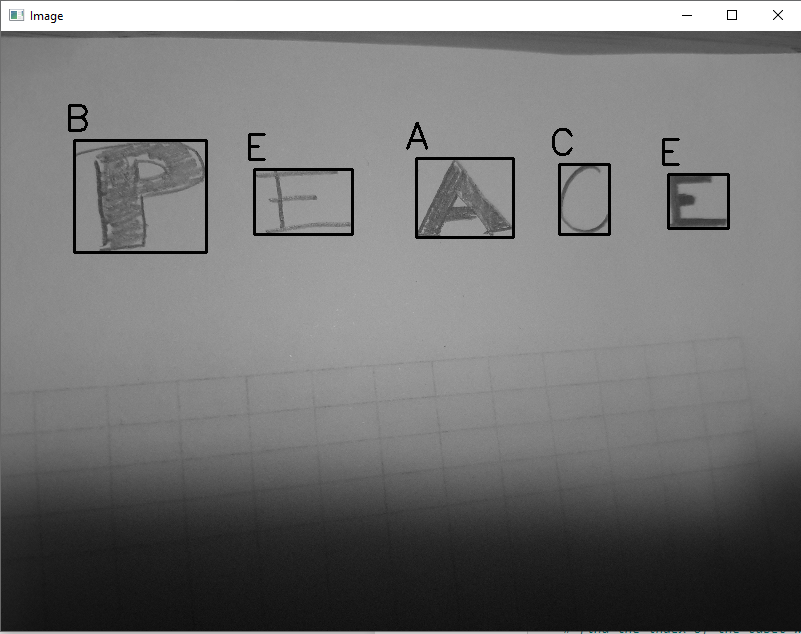


As you can see above, this model made better predictions with high confidence. This shows the importance of model training and  chosing the hyperparameters of model.

If you use this notebook for your own image, please be careful about the filtering and finding contours part. 

REFERENCE LINKS:

* https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html

* https://pyimagesearch.com/2020/08/24/ocr-handwriting-recognition-with-opencv-keras-and-tensorflow/?_ga=2.77586134.2138365318.1655895679-1130789896.1638882117

